# Feature Engineering and Model Training

#### Import required libraries

In [1]:
# Basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# For text Processing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
import string
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# For Classification model selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,\
                            roc_auc_score, roc_curve

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# For data pre-processing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from category_encoders.binary import BinaryEncoder
from imblearn.combine import SMOTETomek

# For Hyperparameter tuning
from hyperopt import tpe, hp, Trials, space_eval
from hyperopt.fmin import fmin
from hyperopt.pyll import scope

#### Importding the data from source

In [2]:
df_full = pd.read_parquet('data/f_complaint.parquet')

In [3]:
df_full.replace('', np.nan, inplace=True)

In [4]:
df = df_full[df_full.consumer_disputed != 'N/A'].reset_index()

#### As per the Final Report of EDA some features can be removed

In [5]:
missing_data = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_data

,0
tags,85.880940
complaint_what_happened,78.653184
company_public_response,74.527538
sub_issue,59.267931
sub_product,30.607068
state,0.735375
zip_code,0.502007
consumer_consent_provided,0.004946
submitted_via,0.000000
consumer_disputed,0.000000


In [6]:
df_full.shape

(5630440, 18)

In [7]:
df.shape

(768316, 19)

#### Company columns can be dropped as it contains 4284 unique values which are names

In [8]:
drop_columns = ['tags', 'complaint_what_happened', 'company_public_response', 
                'sub_issue', 'sub_product', 'zip_code', 'complaint_id']
df.drop(drop_columns, axis=1, inplace=True)

In [9]:
missing_data_up = df.isna().sum().div(df.shape[0]).mul(100).to_frame().sort_values(by=0, ascending = False)
missing_data_up

,0
state,0.735375
consumer_consent_provided,0.004946
index,0.000000
date_received,0.000000
product,0.000000
issue,0.000000
company,0.000000
submitted_via,0.000000
date_sent_to_company,0.000000
company_response,0.000000


- In `state` and `consumer_consent_provided` only 0.7 and 0.04% of missing values. It can be imputed with Simple imputer with mode stratergy

## Feature Extraction

In [10]:
df[['date_received', 'date_sent_to_company']].head(5)

,date_received,date_sent_to_company
0,2012-03-01,2012-06-01
1,2012-03-02,2012-10-25
2,2013-08-23,2013-08-23
3,2012-05-22,2012-05-30
4,2012-04-25,2012-04-25


- Here dataset has two date features, `date_received` which is the date on which the complaint was registered to CFPB and `date_sent_to_company` is when the complaint has been sent the respective company.

In [11]:
# difference between complaint recieved vs data complaint sent to the company
df['days_to_forward_complaint'] = pd.to_datetime(df.date_sent_to_company) - pd.to_datetime(df.date_received)

# Get the days in datetime days (numeric) format
df['days_to_forward_complaint'] = df['days_to_forward_complaint'].dt.days

In [12]:
# After creating the days_to_forward_complaint, both the date columns can be removed
df.drop(['date_sent_to_company', 'date_received'], axis=1, inplace=True)

The feature days to forward complaint has information about the duration taken for CFPB to forward the complaint to companies

### For model to reduce computation time we can use sample of the data for model

In [13]:
# Get a sample data to perform model training

df1 = df.groupby('consumer_disputed').sample(n=50000)
df1.reset_index(inplace=True)

## Text Processing

### For Vectorization

- **TF-IDF**
- **CountVectorizer**
- **NLTH/Spicy Library**
- **Pretrained Glove**


- **Here we can use TF-IDF to process**


### Steps for text processing

- **Remove Punctuation**
- **Remove Stopwords**
- **Lower Casing**
- **Tokenization**
- **Stemming/Lemmatization**



1. The `issue` column has text which has to be preprocessed.
2. The text needs to be transformed into vectors so as the algorithms will be able to make predictions. In this case, it will be used the Term Frequency - Inverse Document Frequesncy (TF-IDF) weight to evaluate how important a word is to a document in a collection of documents.
3. After removing punctuation and lower casing the words, the importance of a word is determined in terms of its frequency.

### Create list of stop words which has to be removed

In [14]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [15]:
# function to tokenize data and remove stopwords
def process_text(issue):
    
    # create tokens
    tokens = nltk.word_tokenize(issue)
    
    # remove common stopwords
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopwords_list]
    
    # remove stopwords including few punctuation
    stopwords_removed = [word for word in stopwords_removed if word.isalpha()]
    
    return stopwords_removed

# concat the strings
def concat_strings(words_list):
    concat_words = ''
    for word in words_list:
        concat_words += word + ' '
    return concat_words.strip()

# function to lemmatize words and merge each complaint into a single space-separated string
lemm = WordNetLemmatizer()

def lemmatizer_concat(words_list):
    
    #remove any NaN's
    list_of_words = [i for i in words_list if i is not np.nan]
    
    # lemmatize each word
    lemmatized_list = []
    
    for idx, word in enumerate(words_list):
        lemmatized_list.append(lemm.lemmatize(word))
        
    # make the list into a single string with the words seperated by ' '
    final_string = concat_strings(lemmatized_list)
    return final_string
    

### Prepare data with text processing

In [16]:
for i in range(len(df1)):
    text = process_text(df1['issue'].loc[i])
    final_texts = lemmatizer_concat(text)
    df1['issue'].iloc[i] = final_texts
    if i % 5000 == 0:
        print(f"Processed Row Number {i}")

Processed Row Number 0
Processed Row Number 5000
Processed Row Number 10000
Processed Row Number 15000
Processed Row Number 20000
Processed Row Number 25000
Processed Row Number 30000
Processed Row Number 35000
Processed Row Number 40000
Processed Row Number 45000
Processed Row Number 50000
Processed Row Number 55000
Processed Row Number 60000
Processed Row Number 65000
Processed Row Number 70000
Processed Row Number 75000
Processed Row Number 80000
Processed Row Number 85000
Processed Row Number 90000
Processed Row Number 95000


### Vectorizing the processed texts

In [17]:
tfidf_vect = TfidfVectorizer(max_features=None, strip_accents='unicode', analyzer='word', ngram_range=(1,2))

# Get data after vectorizing issue column
df_vect = tfidf_vect.fit_transform(df1['issue'])

feature_names = tfidf_vect.get_feature_names()

## Data Preprocessing

#### Concat old data with vectorized data from issue text column

In [18]:
df1 = pd.concat([df1, pd.DataFrame(df_vect.toarray())], axis=1)

#### After processing issue column as vectors, Now issue column can be removed

In [19]:
df1.drop(['issue', 'index'], axis=1, inplace=True)

In [20]:
from sklearn.model_selection import train_test_split
X = df1.drop(['consumer_disputed'], axis=1)
y = df1['consumer_disputed']

In [21]:
# check shape of Train data
X.shape

(100000, 323)

In [22]:
df.columns

Index(['index', 'product', 'issue', 'company', 'state',
       'consumer_consent_provided', 'submitted_via', 'company_response',
       'timely', 'consumer_disputed', 'days_to_forward_complaint'],
      dtype='object')

### Initialize features for transformation

In [23]:
# for binary encoder
binary_features = ['product', 'state', 'submitted_via', 'company_response']

# for onehot encoder
onehot_features = ['consumer_consent_provided', 'timely', 'state', 'company']

numerical_feature = []

### Create column_transformer for transformation

In [24]:
onehot_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('OneHot_encoder', OneHotEncoder())
])
binary_encoder_pipeline = Pipeline(steps=[
    ('SimpleImputer', SimpleImputer(strategy='most_frequent')),
    ('BinaryEncoder', BinaryEncoder())
])

# Getting data pre processor object
preprocessor = ColumnTransformer([
    ('Categorical_Pipeline', onehot_encoder_pipeline, onehot_features),
    ('Binary_encoder_pipeline', binary_encoder_pipeline, binary_features),
    ('Numeric_Pipeline', RobustScaler(), numerical_feature)
    ],
    remainder='passthrough'
)


### Transforming the data for modelling

In [25]:
# fit transform the train data
X = preprocessor.fit_transform(X)

### Manually Encoding Target modelling

In [26]:
# manually encoding "Yes" as 0 and "No" as 1
y = np.where(y.values=="Yes", 0, 1)

## Handeling Imbalanced Dataset

### Handeling Imbalanced Target Variable

- **Synthetic Minority Oversampling Technique or SMOTE is another technique to oversample the minority class. Simply adding duplicate records of minority class often do not add new information to the model.**
- **SMOTE is one of the famous oversampling techniques and is very effective in handling class imbalance. The idea is to combine SMOTE with some undersampling techniques (ENN, Tomek) to increase the effectiveness of handling the imbalanced class**

In [27]:
# Resampling the miniority class The strategy can be changed as required
smt = SMOTETomek(random_state=42, sampling_strategy='minority', n_jobs=-1)

# Fit the model to generate the data.
X_res, y_res = smt.fit_resample(X, y)

## Model Selection

### Here should understand the Various Classification models with default values from these models we can choose top 4 with Highest Accuracy score and procedd with HyperParameter Tuning

In [28]:
# Function which returns all evaluation metrics for classification model

def evaluate_clf(true, predicted):
    acc = accuracy_score(true, predicted) # calculated Accuracy
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    recall = recall_score(true, predicted)
    roc_auc = roc_auc_score(true, predicted)
    return acc, f1, precision, recall, roc_auc

In [29]:
# Initialize models which are required for model selection

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
    "AdaBoost Classifier": AdaBoostClassifier()
}

In [30]:
# Create a function which can evaluate models and return a report in DataFrame

def evaluate_models(X, y, models):
    '''
    This function takes in X(dependent features) and y(target feature) models as input
    It splits the data into Train and Test split
    Iterates through the given model dictionary and evaluates the metrics
    Returns: DatatFrame ehich contains report of all models metrics with cost
    '''
    
    # Separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    models_list = []
    accuracy_list = []
    auc = []
    
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, y_train) # Train model
        
        #Make Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)
        
        #Training set performance
        model_train_accuracy, model_train_f1, model_train_precision, \
        model_train_recall, model_train_rocauc_score = evaluate_clf(y_train, y_train_pred)
        
        # Test set Performance
        model_test_accuracy, model_test_f1, model_test_precision, \
        model_test_recall, model_test_rocauc_score = evaluate_clf(y_test, y_test_pred)
        
        
        print(list(models.keys())[i])
        models_list.append(list(models.keys())[i])
        
        print('Model performance for Training set')
        print(f'~ Accuracy: {model_test_accuracy: .4f}')
        accuracy_list.append(model_test_accuracy)
        print(f'~ F1 Score: {model_test_f1: .4f}')
        print(f'~ Precision: {model_test_precision: .4f}')
        print(f'~ Recall: {model_test_recall: .4f}')
        print(f'~ ROC AUC Score: {model_test_rocauc_score: .4f}')
        auc.append(model_test_rocauc_score)
        print('='*35)
        print('\n')
        
        
    report = pd.DataFrame(list(zip(models_list, accuracy_list)),
                         columns=['Model Name', 'Accuracy']).sort_values(by=['Accuracy'], ascending=False)
    
    return report

### Base report of all models with default parameters

In [31]:
base_report = evaluate_models(X=X_res, y= y_res, models=models)

Random Forest
Model performance for Training set
~ Accuracy:  0.5778
~ F1 Score:  0.5755
~ Precision:  0.5788
~ Recall:  0.5722
~ ROC AUC Score:  0.5778


Decision Tree
Model performance for Training set
~ Accuracy:  0.5684
~ F1 Score:  0.5680
~ Precision:  0.5687
~ Recall:  0.5672
~ ROC AUC Score:  0.5684


Gradient Boosting
Model performance for Training set
~ Accuracy:  0.6211
~ F1 Score:  0.6104
~ Precision:  0.6283
~ Recall:  0.5935
~ ROC AUC Score:  0.6211


Logistic Regression
Model performance for Training set
~ Accuracy:  0.5001
~ F1 Score:  0.6668
~ Precision:  0.5001
~ Recall:  1.0000
~ ROC AUC Score:  0.5000


K-Neighbors Classifier
Model performance for Training set
~ Accuracy:  0.5964
~ F1 Score:  0.6034
~ Precision:  0.5934
~ Recall:  0.6138
~ ROC AUC Score:  0.5964


XGBClassifier
Model performance for Training set
~ Accuracy:  0.6337
~ F1 Score:  0.6342
~ Precision:  0.6335
~ Recall:  0.6348
~ ROC AUC Score:  0.6337


CatBoosting Classifier
Model performance for Traini

### Report in DataFrame

In [32]:
base_report

,Model Name,Accuracy
5,XGBClassifier,0.633668
6,CatBoosting Classifier,0.632041
2,Gradient Boosting,0.621073
7,AdaBoost Classifier,0.611378
4,K-Neighbors Classifier,0.596448
0,Random Forest,0.577767
1,Decision Tree,0.568426
3,Logistic Regression,0.500142


- **Here we can user CatBoost Classifier, XGBClassifier for Hyper Parameter Tuning**

## Hyperopt: Distributed Hyperparameter Optimization

- **Hyperopt is a powerful python library for hyperparameter optimization developed by James Bergstra, Hyperpot uses a form of Bayesian optimization for parameter tuning that allows you to get the best parameters for a given model.**
- **Grid Search is exhaustive in case of Resources usage.**
- **Random Search, is random, so could miss the most important values. However, there is a superior method available through the Hyperopt package.**

#### Search space is where Hyperopt really gives you a many sampling options:

- **for categorical parameters you have hp.choice**
- **for integers you get hp.randint, hp.quniform, hp.qloguniform and hp.qlognormal**
- **for floats we have hp.normal, hp.uniform, hp.lognormal, and hp.loguniform**
- **It is the most extensive sampling functionality out there**

**You define your search space before you run optimization but you can create very complex parameter spaces:**

## Hyperparameter Tuning for XGBoost Model

**This is a function to minimize that recieves hyperparameter values as input from the search space and returns the loss**

In [33]:
# Create an objective function for hyperopt
def XGB_objective(params):
    # Define the parameters
#     params = {
#         'max_depth': int(params['max_depth']),
#         'gamma': params['gamma'],
#         'colsample_bytree': params['colsample_bytree'],
#         'min_child_weight': params['min_child_weight'],
#         'n_estimators': int(params['n_estimators']),
#         'seed': params['seed']
#     }
    model = XGBClassifier(**params, n_jobs=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [34]:
# Define the search space
search_space = {
    'max_depth': scope.int(hp.quniform("max_depth", 3, 10, 1)),
    'gamma': hp.uniform ('gamma', 1, 9),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 10)),
    'seed': 0
}

xgb_trials = Trials()

# Using Fmin function to get best xgb_objective
best_xgb = fmin(
    fn = XGB_objective,
    space=search_space,
    algo=tpe.suggest,
    trials=xgb_trials,
    max_evals=10,
    rstate=np.random.default_rng()
)

100%|████████████████████████████████████████████████| 10/10 [04:05<00:00, 24.57s/trial, best loss: 0.6229833003113501]


In [35]:
print(f"Best Hyperparameters: {best_xgb}")

Best Hyperparameters: {'colsample_bytree': 0.8953669741910344, 'gamma': 8.266832624637509, 'max_depth': 7.0, 'min_child_weight': 3.0, 'n_estimators': 350.0}


- **XGBoost Classifier has accuracy of 61.64%**

## HyperParameter tuning for Catboost model

In [36]:
# Create an objective function for hyperopt for CatBoost
def CatBoost_objective(params):
    # Define the parameters
    model = CatBoostClassifier(**params, verbose=False, thread_count=-1)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)
    model = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    return acc

In [37]:
# Define the search space
search_space_cat = {
    'learning_rate': hp.uniform("learning_rate", 0.001, 1),
    'depth': scope.int(hp.quniform ('max_depth', 2, 10, 1)),
    'iterations': scope.int(hp.quniform('iterations', 50, 1000, 50)),
    'l2_leaf_reg': scope.int(hp.quniform('l2_leaf_reg', 1, 50, 1))
}

cat_trials = Trials()

# Using Fmin function to get best xgb_objective
best_cat = fmin(
    fn = CatBoost_objective,
    space=search_space_cat,
    algo=tpe.suggest,
    trials=cat_trials,
    max_evals=10,
    rstate=np.random.default_rng()
)

100%|████████████████████████████████████████████████| 10/10 [03:48<00:00, 22.88s/trial, best loss: 0.6008349844324936]


In [38]:
print(f"Best Hyperparameters: {best_cat}")

Best Hyperparameters: {'iterations': 550.0, 'l2_leaf_reg': 23.0, 'learning_rate': 0.8193598907905265, 'max_depth': 10.0}


- **CatBoost Classifier has accuracy of 59.20%**

## Final Model

In [45]:
model = CatBoostClassifier(**best_cat, verbose=False, thread_count=-1)

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model = model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

matrix = confusion_matrix(y_test, y_pred)
cm = ConfusionMatrixDisplay(matrix)

In [46]:
best_xgb['max_depth'] = int(best_xgb['max_depth'])
best_xgb['n_estimators'] = int(best_xgb['n_estimators'])
model_x = XGBClassifier(**best_xgb, n_jobs=-1)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

model2 = model_x.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
acc2 = accuracy_score(y_test2, y_pred2)

matrix2 = confusion_matrix(y_test2, y_pred2)
cm2 = ConfusionMatrixDisplay(matrix2)

### Confusion matrix for the Final Catboost model

In [47]:
acc

0.6008349844324936

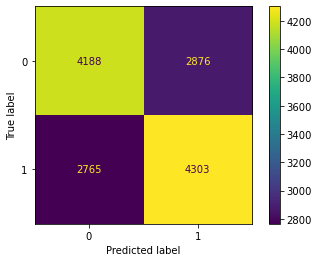

In [48]:
cm.plot()

### Confusion matrix for the Final XGBoost model

In [49]:
acc2

0.6229833003113501

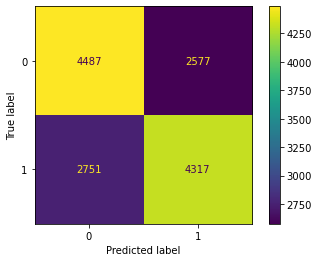

In [50]:
cm2.plot()

# The Best model is XGBoost with a accuracy of 62.29%